In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [17]:
#Load the files 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers.core import Dense, Dropout, Activation



train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
#training data
X_train  = train.drop(['label'], axis=1)
#training labels
Y_target = train['label']

#testing data
test  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

#to free up some space
del train


#print out the first 5 columns of train and test sets and their shapes
print(X_train.head())
print(np.shape(X_train))
print(test.head()) 
print(np.shape(test))

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0   

In [18]:
# normalizing the data (between 0 and 1) to help the CNN with the training
X_train /= 255.0
test /= 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1) 
#chanal is 1 for grey scale images
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

#Lets see the shape of X_train set and test set after normalizaing and reshaping
print("shape of training data after reshaping :-" ,np.shape(X_train))
print("shape of testing data after reshaping :-"  ,np.shape(test))

shape of training data after reshaping :- (42000, 28, 28, 1)
shape of testing data after reshaping :- (28000, 28, 28, 1)


In [19]:
# one-hot encoding using keras (ex : 3 -> [0,0,0,1,0,0,0,0,0,0])
print("Labels Shape before one-hot encoding: ", Y_target.shape)
Y_target = to_categorical(Y_target, 10)
print("Labels Shape after one-hot encoding: ", Y_target.shape)

Labels Shape before one-hot encoding:  (42000,)
Labels Shape after one-hot encoding:  (42000, 10)


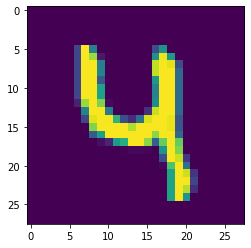

In [20]:
# Split the train and the testing set for the fitting
X_train, X_test, Y_target, Y_test = train_test_split(X_train, Y_target, test_size = 0.1, random_state=0)
g = plt.imshow(X_train[9][:,:,0])

In [26]:
# Set the CNN model 

model = Sequential()


#First Hidden layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#Dropout to avoid overfitting
model.add(Dropout(0.25))

#Second Hidden layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#Dropout to avoid overfitting
model.add(Dropout(0.25))

#Flatten output of conv
model.add(Flatten())

#Fully Connected layer
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(10, activation = "softmax"))


# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


# training the model and saving metrics in history
history = model.fit(X_train, Y_target,
          batch_size=86, epochs=30,
          verbose=2,
          validation_data=(X_test, Y_test))

TypeError: add() got an unexpected keyword argument 'filters'

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,Y_target)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,Y_test)[1]*100 , "%")

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')


plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)